# **Demo Detecting Mistaken Event and Mistaken People in Images**

- **Who task: ** Given a scene and a character, is the character mistaken in any frame in the scene?
- **When task: ** Given a frame, is any character mistaken in the frame?
- **Joint task: ** Given a frame and a character, is the character mistaken in the frame?

Connect to Google Drive to get data and change the directory to the worked folder

In [1]:
#@title Connect to Google Drive
# Code connect to goole drive to get data
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir('drive')
os.chdir('mistaken')

In [1]:
!ls

datalab  drive


In [2]:
#@title Change directory to the worked folder
# change directory to the worked folder
!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir('drive')
os.chdir('mistaken')
!ls -l


total 136475253
drwxr-xr-x 2 root root        4096 Mar  5 06:24 afs
drwxr-xr-x 2 root root        4096 Apr  4 04:26 afs1
-rw-r--r-- 1 root root   353725242 Apr  4 04:22 afs1.zip
-rw-r--r-- 1 root root      269769 Jul 28 03:47 analysis_results.ipynb
-rw-r--r-- 1 root root        1569 Jun 20 14:31 a.npy
drwxr-xr-x 2 root root        4096 Jun 14 05:47 batch_files
-rw-r--r-- 1 root root       34151 Mar  5 09:27 big_living_background.png
-rw-r--r-- 1 root root       47809 Mar  5 09:27 big_park_background.png
-rw-r--r-- 1 root root     7286409 Mar  5 06:26 caffe
-rw-r--r-- 1 root root        9321 May 12 05:55 concatenate_feature.py
drwxr-xr-x 2 root root        4096 Apr 11 11:00 concatenate_feature_resnet50
-rw-r--r-- 1 root root      581355 May  7 04:00 concat_indices_200000000000.json
-rw-r--r-- 1 root root      586640 Apr 16 12:36 concat_indices_2223320934302811922.json
-rw-r--r-- 1 root root      586640 Jun 12 08:10 concat_indices_2408.json
-rw-r--r-- 1 root root      586640 Apr  9 06:12

Import essential library

In [3]:
# import library
# import library
!pip install tqdm
import matplotlib
matplotlib.use('Agg')

import argparse
import copy
import glob
import h5py
import json
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
from render_scenes_json import RenderScenes
from scipy.misc import imsave, imresize
from scipy.ndimage import imread
import shutil
from sklearn.metrics import confusion_matrix, average_precision_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import sys
from tqdm import tqdm
import util

#sys.path.append("/home/ngocthach/caffe/python")

########################################################################
# Global Variables

DATA_PATH = 'data'                              # Where to store temporary files
PUBLIC_PATH = 'public'                          # Where to show graphs and diagnostics
EGOCENTRIC_IMAGE_FOLDER = 'egocentric_images'   # Where egocentric images are stored
TMP_PATH = 'tmp'  


MISTAKEN_TASK                       = True
WHO_TASK                            = True
WHEN_TASK                           = True


import pandas as pd
from scipy import misc


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87, in catch_

In [0]:
# load scene file
# load json file
with open("scene_description.json") as file:
    scenes = json.load(file)

**Check physic scene**

In [14]:
for scene in scenes:
  
  scene_description = json.loads(scenes[scene])['scene_description']
  print(scene + ': ' +  scene_description)
  if 'physics' in scene_description:
    print(scenes)

3L4PIM1GQTF15V4HXI6QEX1FFNDYRC: The man thought he would be done barbequeing before dark.
3JBT3HLQF81GY8Y7GC4KN9A2NU8PZA: woman wonders where the steak went
3QECW5O0KH0GJM7PQ56O3F44AJLT5H: Grandma thinks she sat on her little kitten.
3Z4GS9HPNV988SO11VIKW3QIC2Z77S: The woman thought that her dog would bring his ball back to her. 
3PW9OPU9PQJNB5CT63KGZ2IX1ZH12E: A baby thinks a beehive is a ball.
358010RM5ES4YXVO16PYWGJ9ZCMXV3: A man thinks his cat is going to attack a bird
3Y4W8Q93LZJQ0RQ7A6OM29GHL1TVDY: The cat ate the steak but the man blames the dog.
3ZR9AIQJUB8X7U6YEYZ4ECWLDCU40C: The man thought that the bird would eat the bread
3URFVVM165HTQD63XY3EXFX1VUGUZT: The woman thought the cat was under the table.
3Z7VU45IPYGDHGF5VATUMDS4KP4Z14: boy wonders where his robot went
3KGTPGBS6XK3K23R8RU0A4NU71Z2U4: The man thinks his wife ate his cheese
3QAVNHZ3EM3P6FB1CSVEPZA9BK9LAO: woman wonders where her wine went
3P4RDNWND55YH76ZLVBEQIL0IJUIJ2: man wonders where the pie went
39GXDJN2OTDEJW

**Load pre-train models:** 
- alexnet_single_layer (baseline)
- alexnet_4_1 (NN_4)
- alexnet_7_1 (NN_7)
- alexnet_11_1 (NN_11)
- alexnet_15_1 (NN_15)
- alexnet_7_3_1 (NN_7_3)
- alexnet_14_7_1 (NN_14_7)


In [0]:
#@title Load ground true and prediction score from each models
experiment_hash = 8647626824687750802
feature_hash = 438455043325458450
list_model = ['alexnet_singlelayer', 'alexnet_4_1', 'alexnet_7_1', 'alexnet_11_1', 'alexnet_15_1', 'alexnet_7_3_1', 'alexnet_14_7_1']
result_folder = 'results'

# read y test
y = np.load('y_%d.npy' % feature_hash)

y_dict = {'correct_label': y}


# read y_hat and y_prob of each model

for model in list_model:
  result_folder_temp = os.path.join(result_folder, model)
  y_prob = np.load(os.path.join(result_folder_temp,'y_prob_%d.npy' % experiment_hash))
  y_hat = np.load(os.path.join(result_folder_temp,'y_hat_%d.npy' % experiment_hash))
  
  y_dict[model] = {'y_hat':y_hat, 'y_prob': y_prob}

# load concate_indices file
with open('concat_indices_%d.json' % feature_hash, 'rb') as f:
    concat_indices = json.load(f)
    
split_mask = np.load('split_mask_%d.npy' % experiment_hash)

**Enter a scene and get the result from each model (The scene must be in the test set)**

In [0]:
#@title Function plot images

# function that use to load and show images
def load_and_show(sceneID, count, fig):
  # load image:
  for i in range(8):
    
    frame_key = sceneID + '_' + str(i)

    img_filename = os.path.join('images', sceneID + '_0' + str(i) + '.png')
    
    # initialize subplots in a grid 2x5 at i+1th position
    image = misc.imread(img_filename, mode='RGB')
    ax = fig.add_subplot(3, 3, 1+count) 
    # display image
    ax.imshow(image, cmap=plt.cm.binary)
    
    ## Find questions and answers
    ax.set_title("Frame key: " + str(i))
    #ax.set_title("True: " + test_Y[i])
    #don't show the axes
    plt.axis('off')
    count += 1
  return count

In [51]:
a = filter(lambda scene: scene ==  scene_id, scenes)
a

[]

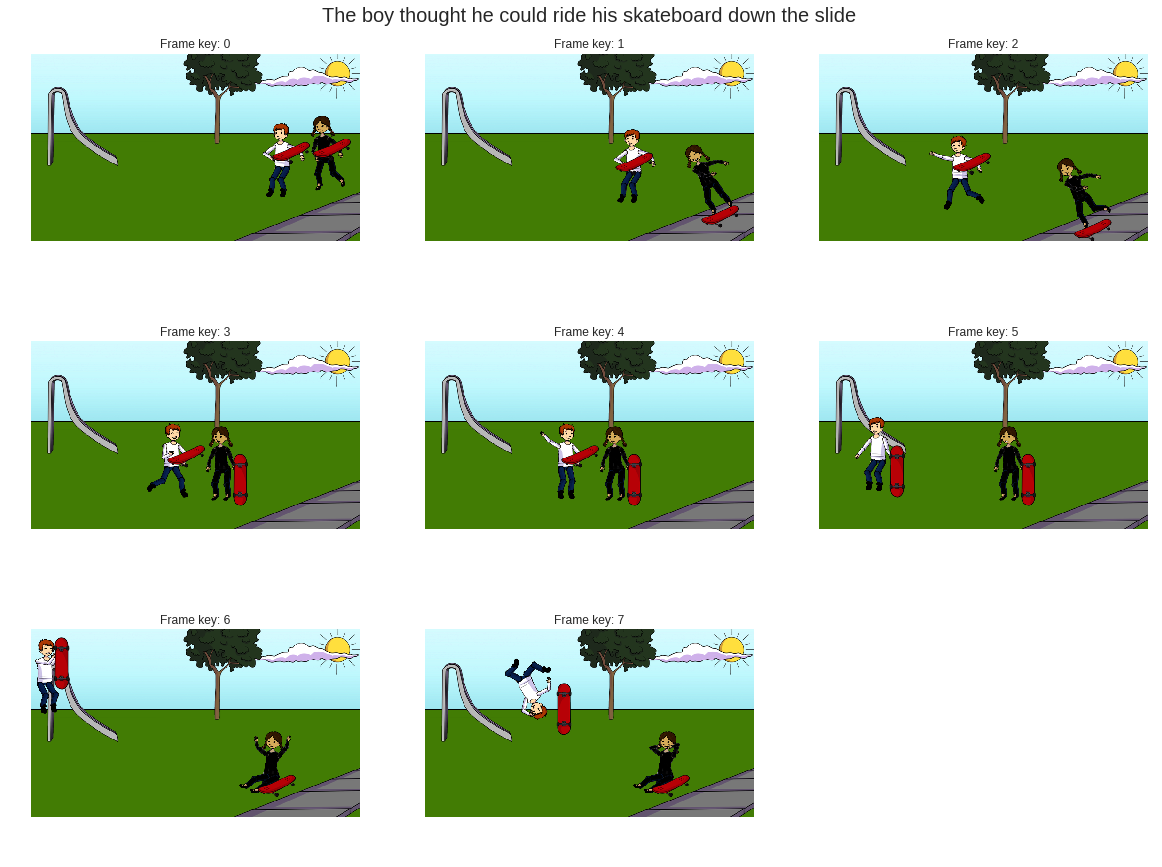

In [18]:
scene_id = '31QNSG6A5RSC86TKB0AQA3MDLPD87S'
#scene_id = '3570Y55XZPIAG5V3H7CEFTN8HUAYGO' # mistaken 
#scene_id = '3X4JMASXCM8HSTR7TD9RMQ2RQWS0BI' # the boy mistakenly believes he's the only one in the room, he didn't see his sister hide "vd cua anh flipped" 
#scene_id = '31QNSG6A5RSC86TKB0AQA3MDLPD87S'
#scene_id = '33L7PJKHCGXZ64QRO3DRFZEVC1ST89' 

a = filter(lambda scene: scene ==  scene_id, scenes)
scene_description = json.loads(scenes[a[0]])['scene_description']
# show images from the scene
fig = plt.figure(figsize=(20,15))
plt.title(scene_description, fontsize=20)
plt.axis('off')
count = 0
load_and_show(scene_id, count, fig)
plt.show()

In [66]:
#@title Prediction scores of models on Joint task
model_prediction = {}
for (scene_frame_character, index) in concat_indices.items():

  # check if index is for test set
  if split_mask[index] != 'test':
    continue
 
  if scene_id not in scene_frame_character:
    continue

  model_prediction[scene_frame_character] = {}
  model_prediction[scene_frame_character]['correct'] = y_dict['correct_label'][index]
  for model in list_model:
    model_prediction[scene_frame_character][model] = (round(float(y_dict[model]['y_prob'][index]), 3))
      

result_df = pd.DataFrame(model_prediction)
result_df.reindex(list_model + ['correct'])
result_df

""


### **Who task: **Given a scene and a character, is the character mistaken in any frame in the scene?

In [63]:
#@title Prediction of models on Who task
character_vec = set([x.split('_')[2] for (x, value) in model_prediction.items()])

who_result = {}
for character in character_vec:
  
  prediction_vec = {}
  for model in list_model:
    prediction_vec[model] = []
  correct_vec = []
  for (scene_frame_character, dict_model) in model_prediction.items():
    (scene, frame, character_name) = scene_frame_character.split('_')
    # A character may appear in only a subset of the 8 frames. We
    # predict whether he is mistaken based on predictions from those
    # frames.
    
    if character_name == character:
      correct_vec.append(dict_model['correct'])
      
      for model in list_model:
        prediction_vec[model].append(dict_model[model])
    
  who_result[character] = {}
  #who_result['Score_' + character] = {}
  correct = min(correct_vec)
  who_result[character]['correct'] = correct
  # add score
  #who_result['Score_' + character]['correct'] = correct
  
  for model in list_model:
      who_result[character][model] = correct == (min(prediction_vec[model])>0.5)
      # add score
      #who_result['Score_' + character][model] = min(prediction_vec[model])

#print("Prediction on Who task")
who_result_df = pd.DataFrame(who_result)
who_result_df
  

,Doll06
alexnet_11_1,True
alexnet_14_7_1,True
alexnet_15_1,True
alexnet_4_1,True
alexnet_7_1,True
alexnet_7_3_1,True
alexnet_singlelayer,True
correct,0


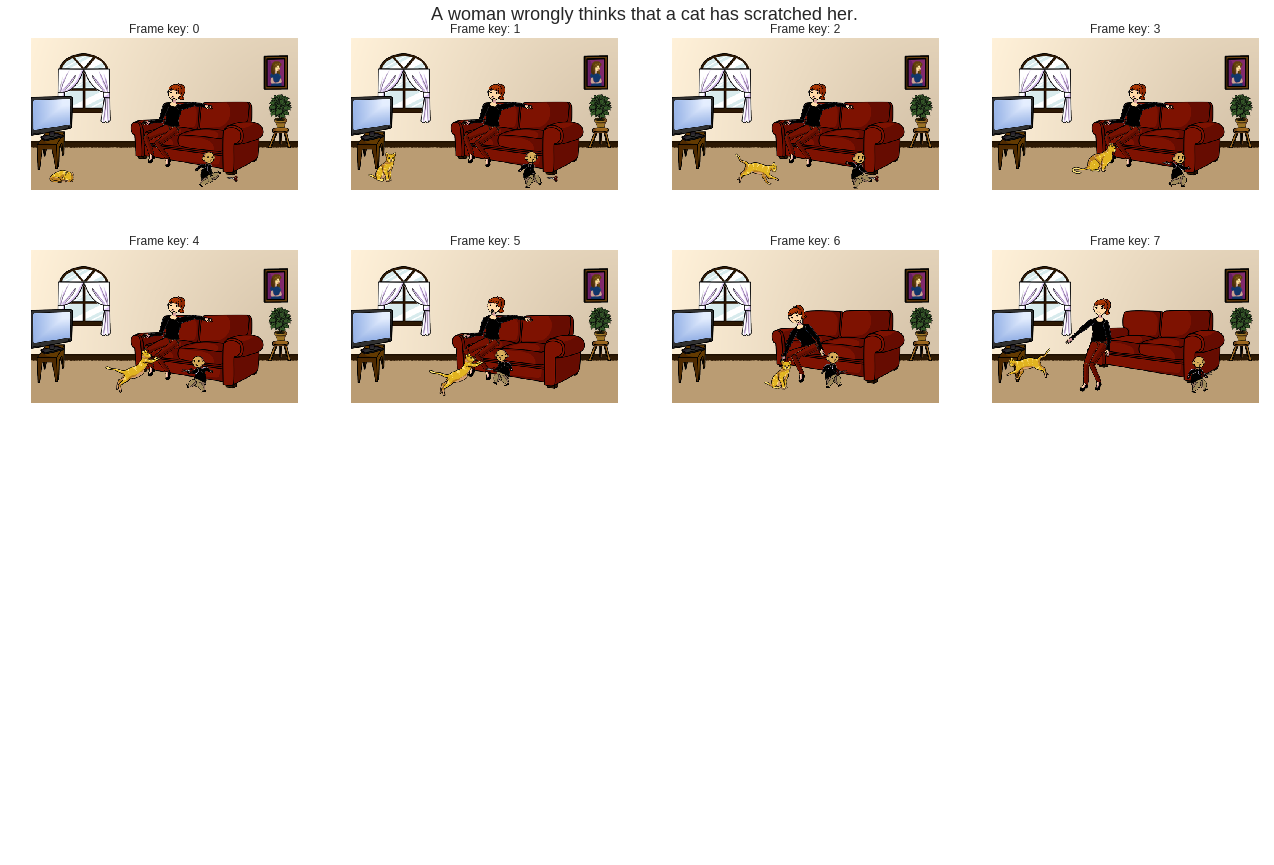

In [26]:
#@title Scene
def load_and_show2(sceneID, count, fig):
  # load image:
  for i in range(8):
    
    frame_key = sceneID + '_' + str(i)

    img_filename = os.path.join('images', sceneID + '_0' + str(i) + '.png')
    
    # initialize subplots in a grid 2x5 at i+1th position
    image = misc.imread(img_filename, mode='RGB')
    ax = fig.add_subplot(4, 4, 1+count) 
    # display image
    ax.imshow(image, cmap=plt.cm.binary)
    
    ## Find questions and answers
    ax.set_title("Frame key: " + str(i))
    #ax.set_title("True: " + test_Y[i])
    #don't show the axes
    plt.axis('off')
    count += 1
  return count

# show images from the scene
fig = plt.figure(figsize=(22,15))
plt.title(scene_description, fontsize=18)
plt.axis('off')
count = 0
load_and_show2(scene_id, count, fig)
plt.show()

### **When task: **Given a frame, is any character mistaken in the frame?

In [27]:
#@title Prediction of models on When task
frame_vec = set([x.split('_')[1] for (x, value) in model_prediction.items()])

when_result = {}
for frame in frame_vec:
  
  prediction_vec = {}
  for model in list_model:
    prediction_vec[model] = []
  correct_vec = []
  for (scene_frame_character, dict_model) in model_prediction.items():
    (scene, frame_id, character_name) = scene_frame_character.split('_')
    # A character may appear in only a subset of the 8 frames. We
    # predict whether he is mistaken based on predictions from those
    # frames.
    
    if frame_id == frame:
      correct_vec.append(dict_model['correct'])
      
      for model in list_model:
        prediction_vec[model].append(dict_model[model])
    
  when_result[frame] = {}
  #who_result['Score_' + frame] = {}
  correct = min(correct_vec)
  when_result[frame]['correct'] = correct
  # add score
  #who_result['Score_' + character]['correct'] = correct
  
  for model in list_model:
      when_result[frame][model] = correct == (min(prediction_vec[model])>0.5)
      # add score
      #who_result['Score_' + character][model] = min(prediction_vec[model])

#print("Prediction on Who task")
when_result_df = pd.DataFrame(when_result)
when_result_df
  

,0,1,2,3,4,5,6,7
alexnet_11_1,False,False,False,True,True,True,True,False
alexnet_14_7_1,True,True,True,True,True,True,True,True
alexnet_15_1,False,False,False,True,True,True,True,False
alexnet_4_1,False,False,False,True,True,True,True,False
alexnet_7_1,True,False,True,True,True,True,True,False
alexnet_7_3_1,False,False,False,True,True,True,True,False
alexnet_singlelayer,False,False,False,True,True,True,True,False
correct,0,0,0,0,0,0,0,0


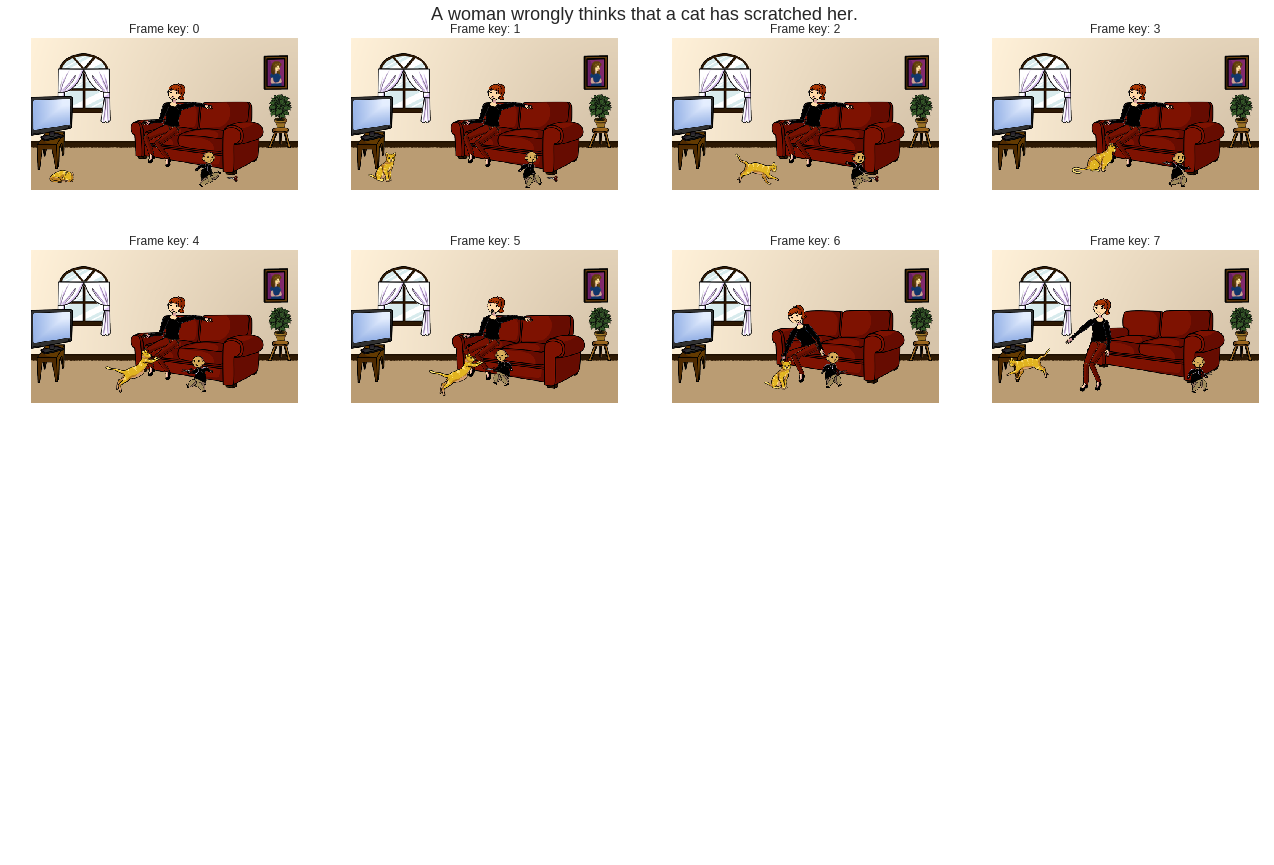

In [28]:
#@title Scene
def load_and_show2(sceneID, count, fig):
  # load image:
  for i in range(8):
    
    frame_key = sceneID + '_' + str(i)

    img_filename = os.path.join('images', sceneID + '_0' + str(i) + '.png')
    
    # initialize subplots in a grid 2x5 at i+1th position
    image = misc.imread(img_filename, mode='RGB')
    ax = fig.add_subplot(4, 4, 1+count) 
    # display image
    ax.imshow(image, cmap=plt.cm.binary)
    
    ## Find questions and answers
    ax.set_title("Frame key: " + str(i))
    #ax.set_title("True: " + test_Y[i])
    #don't show the axes
    plt.axis('off')
    count += 1
  return count


# show images from the scene
fig = plt.figure(figsize=(22,15))
plt.title(scene_description, fontsize=18)
plt.axis('off')
count = 0
load_and_show2(scene_id, count, fig)
plt.show()

In [20]:
split_dict_filename = os.path.join(DATA_PATH, 'split_dict_01.json')
with open(split_dict_filename) as f:
    split_dict = json.load(f)

list_test_scene = []
for (key, value) in split_dict.items():
  if value in ['test']:
    list_test_scene.append(key)

print("List test scene: ")
list_test_scene

List test scene: 


[u'33FBRBDW6OYIKNOG2HI1QPERQZQC8D',
 u'39GXDJN2OTDEJWUGTYD6GH2G9MAV8T',
 u'3NC5L260MOLS8RV600XYVHPU1MSFO9',
 u'3VW04L3ZLT5W2M0J1LQGK1GUFQ1XXJ',
 u'3Y9N9SS8LYA6OIOOQWIGJEOYU8YD3Z',
 u'34HJIJKLP5VD0V7EHVNTZ5MB5SX4VW',
 u'3VAR3R6G1P0JTCLJSMRSLP88G10O8Q',
 u'3M23Y66PO26BNQUO6OB3LGMI5JAS6C',
 u'36WLNQG78Z9GJJ611K867F4VIK5EBT',
 u'34BBWHLWHAAKNR6YSUUTF8F8HJNIWM',
 u'3NG53N1RLVI1ECXK7M47APDYQ6J8PE',
 u'32VNZTT0A73L7OQX8BIJY8X8NGQR4N',
 u'32AT8R96GL8WP1KP26961M0Y5QNSUC',
 u'3A0EX8ZRN8NEPONS1LK0EIWB23JYBH',
 u'3MTMREQS4VH5H9N0G62GYARP4CDAW7',
 u'33IZTU6J810O65EK7BKTLTZ22WDXSX',
 u'3S0TNUHWKTHSPFUU2DDCAVW9AYUD83',
 u'31QNSG6A5RSC86TKB0AQA3MDLPD87S',
 u'3OVR4I9USPILVNBXVWTJTIN3TDN4Q2',
 u'3HHRAGRYX84J7H4TXEX6LL3JY799OP',
 u'3PWWM24LHSX5M5WE5OTVEC55DAQ82G',
 u'3VD82FOHKQNL5FBW9Y7XNB4R1DNCON',
 u'3YJ6NA41JBFQYTT3YQ1YZFMC1V4PJT',
 u'3A7Y0R2P2ONV72VUKHBFTS8F3RWJXO',
 u'34BBWHLWHAAKNR6YSUUTF8F8L8SWIN',
 u'3ZAK8W07I4DWOS0DT4QMRGUFDO10UD',
 u'3CFVK00FWLKOJDZYMFE29U8NAF56LS',
 u'31LM9EDVOLRQV8HQIBO6VQHH5